# Example climb: Matching mean & standard deviation with maximum difference

## 1. Notebook setup

### 1.1. Imports

In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats

sys.path.append('..')

from hill_climber import HillClimber

### 1.2. Run hyperparameters

In [2]:
# Number of input data points
n = 5000

# Run duration in minutes
run_time = 6 * 30

# Number of replicate climbs
replicates = 4

### 1.3. Input distributions

Initial mean X: 4.9887, mean Y: 4.9841
Initial std X: 2.0028, std Y: 1.9850
Initial KS statistic: 0.0146


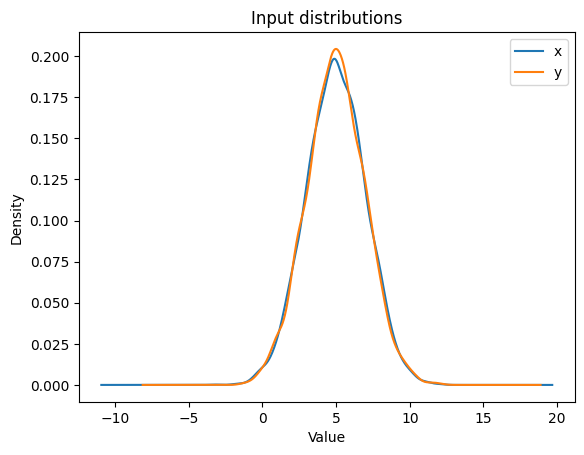

In [3]:
# Create input distribution
data = pd.DataFrame({
    'x': np.random.normal(loc=5.0, scale=2.0, size=n),
    'y': np.random.normal(loc=5.0, scale=2.0, size=n)
})

print(f"Initial mean X: {np.mean(data['x']):.4f}, mean Y: {np.mean(data['y']):.4f}")
print(f"Initial std X: {np.std(data['x'], ddof=1):.4f}, std Y: {np.std(data['y'], ddof=1):.4f}")
print(f"Initial KS statistic: {stats.ks_2samp(data['x'], data['y'])[0]:.4f}")

# Visualize using KDE plots to show distribution shapes
data['x'].plot.kde(label='x')
data['y'].plot.kde(label='y')
plt.title('Input distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

## 2. Maximize distribution difference

### 2.1. Objective function

In [ ]:
def objective_same_mean_std_different_distributions(x, y):
    '''Maximize distribution difference while maintaining same mean and std.
    
    Objective function: KS_statistic - penalty_weight * penalty
    
    Where penalty = (|mean_x - mean_y| / mean_scale) + (|std_x - std_y| / std_scale)
    
    This encourages:
        - Identical means between x and y
        - Identical standard deviations between x and y
        - Maximum Kolmogorov-Smirnov statistic (most different distributions)
    
    The KS statistic measures the maximum difference between cumulative 
    distribution functions, providing a measure of how different two 
    distributions are overall.
    
    Args:
        x: First variable (array-like)
        y: Second variable (array-like)
    
    Returns:
        Tuple of (metrics_dict, objective_value) where:
            - metrics_dict: Dict with means, stds, KS statistic, and penalty
            - objective_value: KS_statistic - penalty
    '''

    mean_x = np.mean(x)
    mean_y = np.mean(y)
    std_x = np.std(x, ddof=1)
    std_y = np.std(y, ddof=1)
    
    # Calculate KS statistic (measure of distribution difference)
    ks_statistic, _ = stats.ks_2samp(x, y)
    
    # Calculate penalty for not matching mean and std
    # Scale by typical values to balance with KS statistic (which is 0-1)
    mean_scale = (abs(mean_x) + abs(mean_y)) / 2 + 0.1  # Avoid division by zero
    std_scale = (std_x + std_y) / 2 + 0.1
    
    mean_penalty = abs(mean_x - mean_y) / mean_scale
    std_penalty = abs(std_x - std_y) / std_scale
    total_penalty = mean_penalty + std_penalty
    
    # Objective: maximize KS statistic while minimizing penalty
    # Use lower penalty weight (0.5) to allow more freedom for KS to increase
    penalty_weight = 0.5
    objective = ks_statistic - (penalty_weight * total_penalty)
    
    metrics = {
        'Mean X': mean_x,
        'Mean Y': mean_y,
        'Std X': std_x,
        'Std Y': std_y,
        'KS Statistic': ks_statistic,
        'Mean Penalty': mean_penalty,
        'Std Penalty': std_penalty,
        'Total Penalty': total_penalty
    }
    
    return metrics, objective

### 2.2. Run parameters

In [5]:
# Set hyperparameters
step_size = 3.0
perturb_fraction = 0.4
temperature = 1000.0
initial_noise = 0.8
cooling_rate = 0.999
objective_func = objective_same_mean_std_different_distributions

### 2.3. Hill climbing run

In [ ]:
# Create HillClimber instance
climber = HillClimber(
    data=data,
    objective_func=objective_func,
    max_time=run_time,
    step_size=step_size,
    perturb_fraction=perturb_fraction,
    temperature=temperature,
    cooling_rate=cooling_rate,
    mode='maximize'
)

# Run parallel optimization
results = climber.climb_parallel(
    replicates=replicates,
    initial_noise=initial_noise
)

### 2.4. Results

In [ ]:
# Display KS Statistic and penalty metrics using KDE plots
climber.plot_results(results, plot_type='histogram', metrics=['KS Statistic', 'Total Penalty'])

In [ ]:
# Save the climber object
with open('../data/03_same_mean_std_different_distributions.pkl', 'wb') as f:
    pickle.dump(climber, f)